<a href="https://colab.research.google.com/github/Carlos-Muniz/United-States-Plants-Clustering/blob/master/plant_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# United States Plants
* **Problem**: United States Plant location by state - Clustering
* **Dataset**: [Plant Data Set](https://archive.ics.uci.edu/ml/machine-learning-databases/plants/)
* **Methods**: A  Variety of Clustering Algorithms
* **Evaluation**:

## Contents
1. Import Libraries
2. Load Dataset
3. Exploratory Data Analysis
4. Clustering
5. Evaluation

# Import Libraries

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://downloads.apache.org/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [3]:
import findspark
findspark.init("spark-2.4.5-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import pyspark.sql.types as st

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Load Dataset

In [5]:
with open('plants.data', 'r', encoding='cp1252') as fin:
    data = fin.read().splitlines()

with open('stateabbr.txt', 'r', encoding='cp1252') as fin:
    states = fin.read().splitlines()

In [6]:
statesDict = {}
statesVector = {}
for i, s in enumerate(states[3:56]):
    stateSplit = s.split()
    abbreviation = stateSplit[0]
    stateName = " ".join(stateSplit[1:])
    statesDict[abbreviation] = stateName
    statesVector[abbreviation] = i

In [7]:
cols = [' '] * (len(statesVector) + 1)
cols[0] = 'plant'
for k, v in statesVector.items():
    cols[v+1] = k
cleanData = []
for d in data:
    splitData = d.split(',')
    row = [splitData[0]]
    row.extend([0]*len(statesVector))
    for s in splitData[1:]:
        if s in statesVector:
            row[statesVector[s] + 1] = 1
    cleanData.append(row)

In [8]:
schemaCols = [st.StructField(c, st.IntegerType(), True) for c in cols[1:]]
schemaCols.insert(0,st.StructField(cols[0], st.StringType(), True))
dfSchema = st.StructType(schemaCols)
df = spark.createDataFrame(cleanData, dfSchema)

In [9]:
# df.printSchema()
df.show(3)

+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|               plant| ab| ak| ar| az| ca| co| ct| de| dc| fl| ga| hi| id| il| in| ia| ks| ky| la| me| md| ma| mi| mn| ms| mo| mt| ne| nv| nh| nj| nm| ny| nc| nd| oh| ok| or| pa| pr| ri| sc| sd| tn| tx| ut| vt| va| vi| wa| wv| wi| wy|
+--------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|              abelia|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  1|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
|abelia x grandiflora|  0|  0|  0|  0|  0|  0|  0|  0|  0|  

# Exploratory Data Analysis

In [10]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = cols[1:], outputCol = 'features')
dfVectors = vectorAssembler.transform(df).select("plant", "features")

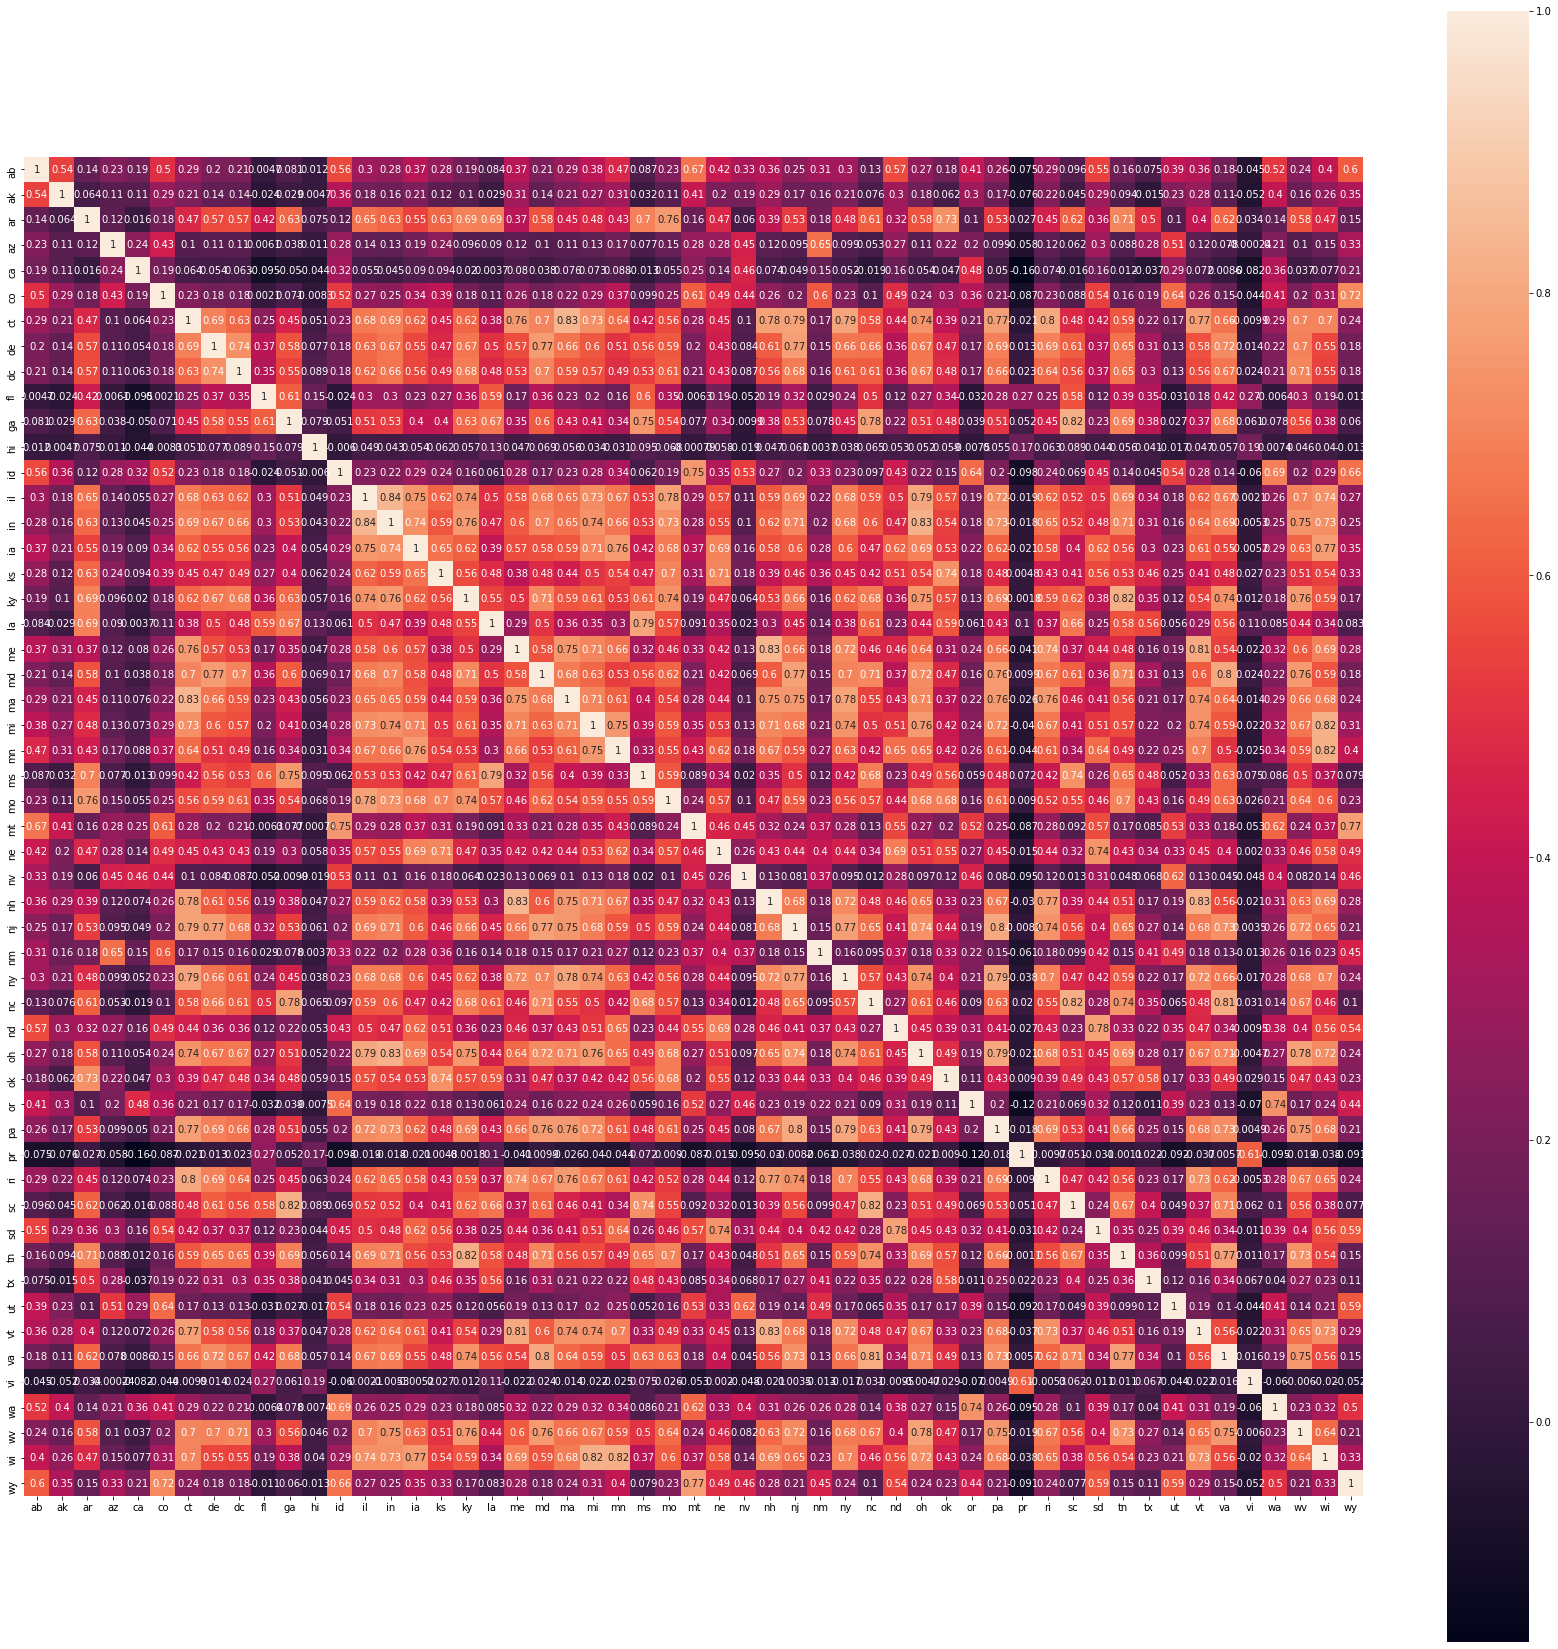

In [12]:
from pyspark.ml.stat import Correlation
matrix = Correlation.corr(dfVectors, "features").collect()[0][0]
corrmatrix = matrix.toArray()
fig = plt.figure(figsize=(30,30))
sns.heatmap(corrmatrix, annot=True, square=True, xticklabels=cols[1:], yticklabels=cols[1:])

In [13]:
n = len(cols[1:])
rankedCorrelations = []
for i in range(n):
    for j in range(i+1, n):
        rankedCorrelations.append(
            [corrmatrix[i,j], (cols[i+1], cols[j+1])])
rankedCorrelations.sort(reverse=True)
rankedCorrelations[:20]

[[0.8416817810739237, ('il', 'in')],
 [0.8346939788977901, ('ct', 'ma')],
 [0.8339142726317565, ('me', 'nh')],
 [0.8272011180780274, ('nh', 'vt')],
 [0.8253229725324557, ('in', 'oh')],
 [0.8205156260376496, ('mi', 'wi')],
 [0.8192475897647328, ('ky', 'tn')],
 [0.8192056644342194, ('ga', 'sc')],
 [0.8164128222927273, ('mn', 'wi')],
 [0.8161859871671291, ('nc', 'sc')],
 [0.8078850116192068, ('nc', 'va')],
 [0.8050886960065691, ('me', 'vt')],
 [0.8002014576010069, ('ct', 'ri')],
 [0.7993794344059036, ('md', 'va')],
 [0.797376489944295, ('nj', 'pa')],
 [0.7943512799147588, ('ny', 'pa')],
 [0.7932519178894708, ('il', 'oh')],
 [0.7928134499650917, ('oh', 'pa')],
 [0.7918076198084631, ('ct', 'ny')],
 [0.7881410132450564, ('la', 'ms')]]

It's with little surpise that the states that share the most plants, also border eachother. From these pairs, it is possible to form a graph and show the relationships between the states.

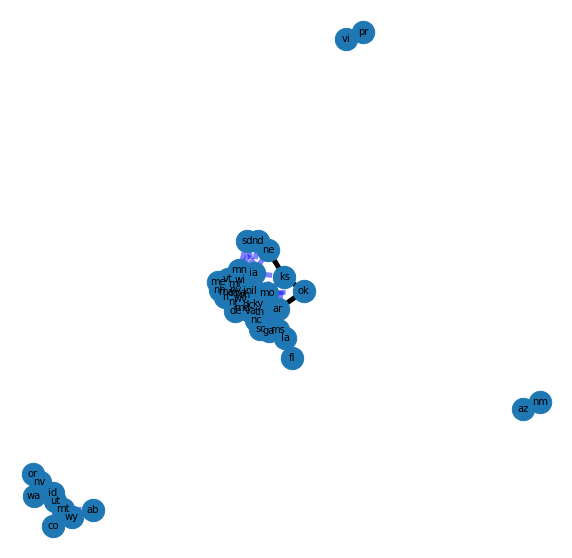

In [14]:
G = nx.Graph()
for w, c in rankedCorrelations:
    if w > 0.6:
        a, b = c
        G.add_edge(a, b, weight=w)
elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] > 0.7]
esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d['weight'] <= 0.7]
pos = nx.spring_layout(G)
fig = plt.figure(figsize=(10,10))
nx.draw_networkx_nodes(G, pos, node_size=500)
nx.draw_networkx_edges(G, pos, edgelist=elarge,
                       width=5)
nx.draw_networkx_edges(G, pos, edgelist=esmall,
                       width=5, alpha=0.5, edge_color='b', style='dashed')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()

From this Graph, we can see how the correlations naturally form these clusters of states with similar plants. States naturally cluster themselves by location.

In [ ]:
# TODO: Graph clusters on actual map of USA
# Using Basemap or Geopy
# https://towardsdatascience.com/planning-to-travel-around-the-world-with-python-42fac1d21a6e
# https://towardsdatascience.com/mapping-with-matplotlib-pandas-geopandas-and-basemap-in-python-d11b57ab5dac

# Clustering

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

In [24]:
def dfCol2List(dfCol):
    return dfCol.rdd.flatMap(lambda x: x).collect()

In [25]:
for k in range(2, 20):
    kmeans = KMeans().setK(k).setSeed(1)
    model = kmeans.fit(dfVectors)
    predictions = model.transform(dfVectors)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    print("K: ", k)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

K:  2
Silhouette with squared euclidean distance = 0.720395336360912
K:  3
Silhouette with squared euclidean distance = 0.5753694460728789
K:  4
Silhouette with squared euclidean distance = 0.22563666480290132
K:  5
Silhouette with squared euclidean distance = 0.1622503641618687
K:  6
Silhouette with squared euclidean distance = 0.49482790181717407
K:  7
Silhouette with squared euclidean distance = 0.45670735956646424
K:  8
Silhouette with squared euclidean distance = 0.2840808021807478
K:  9
Silhouette with squared euclidean distance = 0.281786977046886
K:  10
Silhouette with squared euclidean distance = 0.23307974367609796
K:  11
Silhouette with squared euclidean distance = 0.23396745358024967
K:  12
Silhouette with squared euclidean distance = 0.189203469298689
K:  13
Silhouette with squared euclidean distance = 0.22815711090447044
K:  14
Silhouette with squared euclidean distance = 0.20860653705808122
K:  15
Silhouette with squared euclidean distance = 0.2048091578532891
K:  16
Sil

Let's look closer at the K's with the top 7 Sillouette scores.

# Evaluation

For n_clusters = 2 The average silhouette_score is : 0.5193006054570554
For n_clusters = 3 The average silhouette_score is : 0.3871658145046918
For n_clusters = 6 The average silhouette_score is : 0.3263673465877068
For n_clusters = 7 The average silhouette_score is : 0.2973909209221825
For n_clusters = 8 The average silhouette_score is : 0.18547695709537013
For n_clusters = 9 The average silhouette_score is : 0.18399873955243395
For n_clusters = 18 The average silhouette_score is : 0.22478950943257592


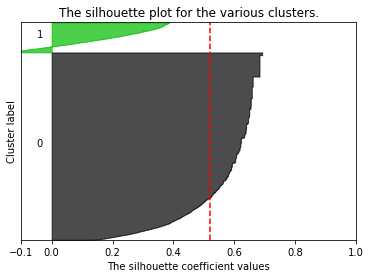

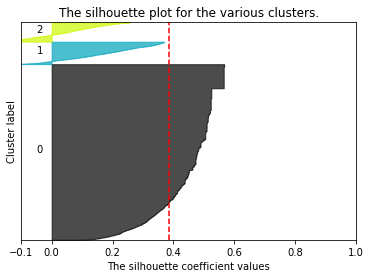

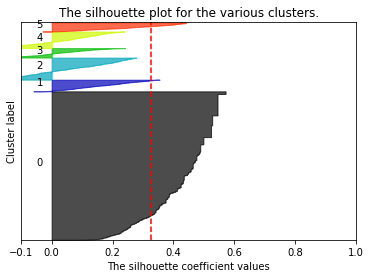

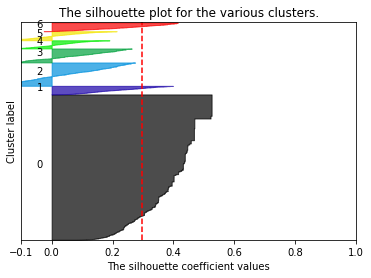

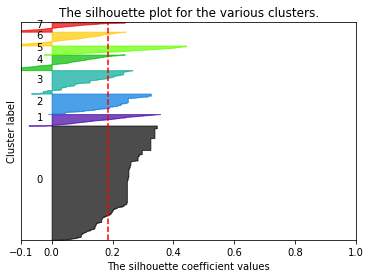

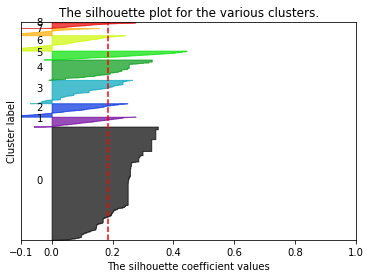

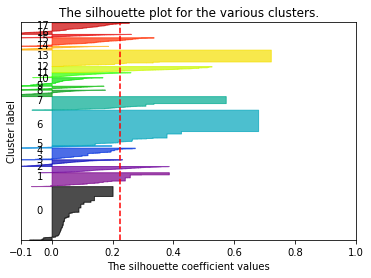

In [34]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
import pdb

kValues = [2, 3, 6, 7, 8, 9, 18]
for n_clusters in kValues:
    fig, ax = plt.subplots(1, 1)
    ax.set_xlim([0, 1])
    X = dfCol2List(dfVectors.select("features"))
    ax.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    kmeans = KMeans().setK(n_clusters).setSeed(1)
    model = kmeans.fit(dfVectors)
    predictions = model.transform(dfVectors)
    cluster_labels = np.array(dfCol2List(predictions.select("prediction")))
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    sample_silhouette_values = silhouette_samples(X, cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        # pdb.set_trace()
        ax.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10
    ax.set_title("The silhouette plot for the various clusters.")
    ax.set_xlabel("The silhouette coefficient values")
    ax.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax.set_yticks([])  # Clear the yaxis labels / ticks
    ax.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()